Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [29]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [30]:
# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmnist.ipynb_.

In [31]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [32]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [33]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Saving Model Accuracy

We'll plot a graph with the accuracy results of each model at the end of the assignment.

In [34]:
methodDict = {}

#### Logistic model

In [35]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [37]:
num_steps = 3001
losses = []
acc = []
valid_acc = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))

      losses.append(l)
      acc.append(accuracy(predictions, batch_labels))
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
 
  methodDict['Logistic model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)

Initialized
Minibatch loss at step 0: 25.348778
Minibatch accuracy: 0.8%
Validation accuracy: 7.9%
Minibatch loss at step 500: 2.525017
Minibatch accuracy: 80.5%
Validation accuracy: 77.5%
Minibatch loss at step 1000: 1.837624
Minibatch accuracy: 77.3%
Validation accuracy: 78.8%
Minibatch loss at step 1500: 1.252073
Minibatch accuracy: 81.2%
Validation accuracy: 80.7%
Minibatch loss at step 2000: 0.897530
Minibatch accuracy: 78.9%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.949627
Minibatch accuracy: 75.8%
Validation accuracy: 81.0%
Minibatch loss at step 3000: 0.993317
Minibatch accuracy: 78.1%
Validation accuracy: 82.4%
Test accuracy: 88.8%
{'Logistic model': 88.83}


### Plotting loss and accuracy by step

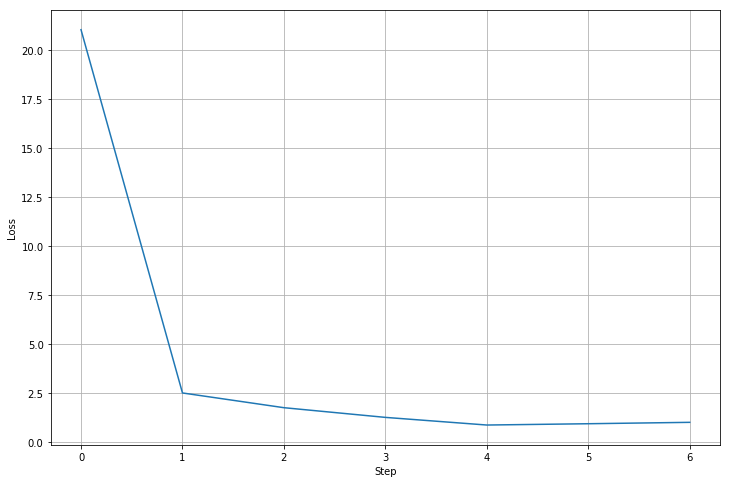

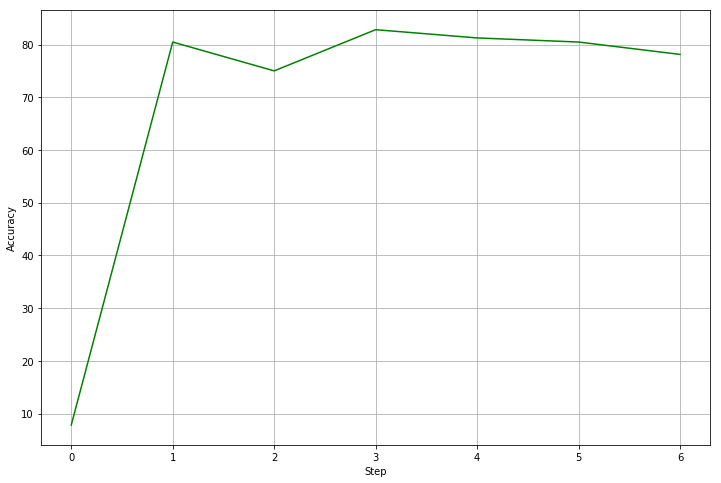

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(acc, color='g')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.grid(True)
plt.show()

### Neural Network L2 regularization
In L2 regularization there is a new regularization parameter. The right amount of regularization should improve your validation / test accuracy. Let's see what the best value for that parameter.

In [10]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
print("Initialized")
for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
    print("Test Regul./Accuracy: '%.3e'" % regul, accuracy_val[-1])
print("Ended") 

Initialized
Test Regul./Accuracy: '1.000e-04' 86.46
Test Regul./Accuracy: '1.259e-04' 86.09
Test Regul./Accuracy: '1.585e-04' 86.67
Test Regul./Accuracy: '1.995e-04' 87.02
Test Regul./Accuracy: '2.512e-04' 87.25
Test Regul./Accuracy: '3.162e-04' 87.41
Test Regul./Accuracy: '3.981e-04' 87.91
Test Regul./Accuracy: '5.012e-04' 87.97
Test Regul./Accuracy: '6.310e-04' 88.44
Test Regul./Accuracy: '7.943e-04' 88.86
Test Regul./Accuracy: '1.000e-03' 88.87
Test Regul./Accuracy: '1.259e-03' 89.07
Test Regul./Accuracy: '1.585e-03' 89.12
Test Regul./Accuracy: '1.995e-03' 89.09
Test Regul./Accuracy: '2.512e-03' 89.15
Test Regul./Accuracy: '3.162e-03' 89.1
Test Regul./Accuracy: '3.981e-03' 89.05
Test Regul./Accuracy: '5.012e-03' 89.03
Test Regul./Accuracy: '6.310e-03' 89.0
Test Regul./Accuracy: '7.943e-03' 88.89
Ended


### Plotting regularization best value parameter 


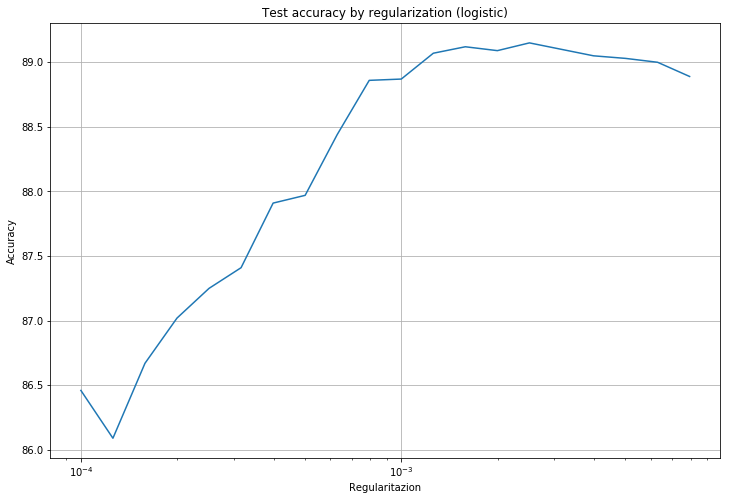

In [11]:
plt.figure(figsize=(12,8))
plt.semilogx(regul_val, accuracy_val)
plt.ylabel('Accuracy')
plt.xlabel('Regularitazion')
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

### L2 regularization

The idea is to add another term to the loss, which penalizes large weights.
It's typically achieved by adding the L2 norm of your weights to the loss, multiplied by a small constant.

Let's try now adding this new parameter.

In [47]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [48]:
num_steps = 3001
losses = []
acc = []
valid_acc = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      losses.append(l)
      acc.append(accuracy(predictions, batch_labels))
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
     
  
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  # Accuray for final results
  methodDict['L2 Reg. model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)    

Initialized
Minibatch loss at step 0: 625.065430
Minibatch accuracy: 7.0%
Validation accuracy: 37.4%
Minibatch loss at step 500: 190.973450
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Minibatch loss at step 1000: 119.693153
Minibatch accuracy: 80.5%
Validation accuracy: 80.4%
Minibatch loss at step 1500: 69.036346
Minibatch accuracy: 84.4%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.173286
Minibatch accuracy: 89.8%
Validation accuracy: 85.6%
Minibatch loss at step 2500: 25.190327
Minibatch accuracy: 85.2%
Validation accuracy: 86.5%
Minibatch loss at step 3000: 15.491286
Minibatch accuracy: 85.2%
Validation accuracy: 87.2%
Test accuracy: 93.1%
{'L2 Reg. model': 93.1, 'Overfitting model': 9.51, 'Logistic model': 88.83}


### Plotting loss and accuracy by step

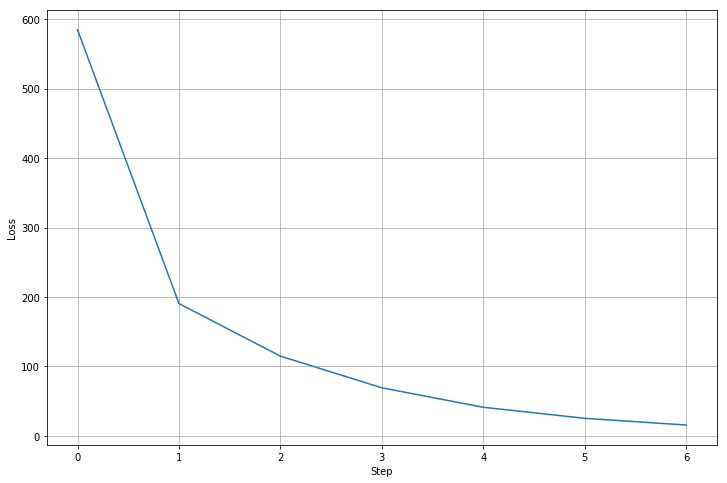

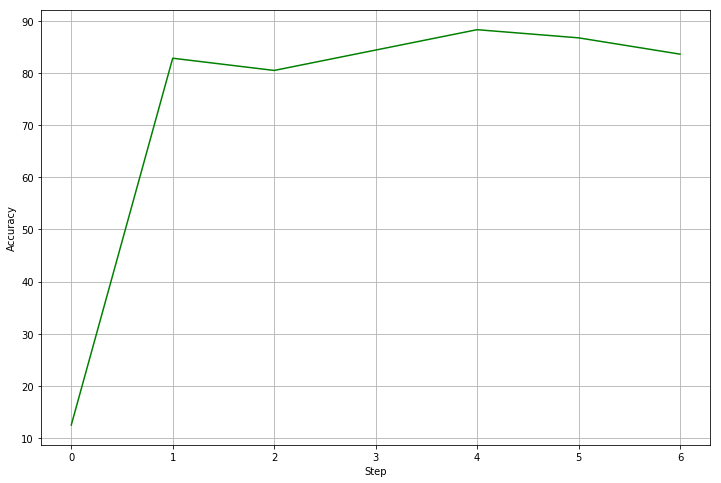

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(acc, color='g')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.grid(True)
plt.show()

In [15]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []


print("Initialized")
for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))  
    
    print("Test Regul./Accuracy: '%.3e'" % regul, accuracy_val[-1])
print("Ended")


Initialized
Test Regul./Accuracy: '1.000e-04' 87.99
Test Regul./Accuracy: '1.259e-04' 88.74
Test Regul./Accuracy: '1.585e-04' 89.39
Test Regul./Accuracy: '1.995e-04' 89.59
Test Regul./Accuracy: '2.512e-04' 89.7
Test Regul./Accuracy: '3.162e-04' 89.97
Test Regul./Accuracy: '3.981e-04' 90.47
Test Regul./Accuracy: '5.012e-04' 90.67
Test Regul./Accuracy: '6.310e-04' 91.34
Test Regul./Accuracy: '7.943e-04' 92.52
Test Regul./Accuracy: '1.000e-03' 93.21
Test Regul./Accuracy: '1.259e-03' 93.67
Test Regul./Accuracy: '1.585e-03' 93.63
Test Regul./Accuracy: '1.995e-03' 93.64
Test Regul./Accuracy: '2.512e-03' 93.07
Test Regul./Accuracy: '3.162e-03' 92.96
Test Regul./Accuracy: '3.981e-03' 92.67
Test Regul./Accuracy: '5.012e-03' 92.42
Test Regul./Accuracy: '6.310e-03' 91.81
Test Regul./Accuracy: '7.943e-03' 91.35
Ended


### Let's plot the L2 parameter accuracy

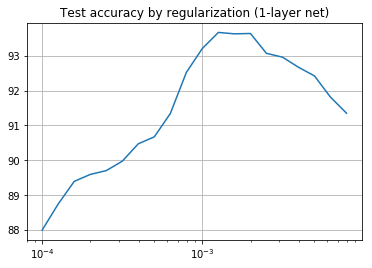

In [16]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

### Conclusion Problem 1

We've got improved Test Accuracy from 89.1% with Logistic Regressioon to 93.2% with a 1-layer Neural Network models.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [49]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [50]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  methodDict['Overfitting model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)    

Initialized
Minibatch loss at step 0: 313.081696
Minibatch accuracy: 10.2%
Validation accuracy: 23.9%
Minibatch loss at step 2: 1417.256836
Minibatch accuracy: 33.6%
Validation accuracy: 37.9%
Minibatch loss at step 4: 695.504089
Minibatch accuracy: 44.5%
Validation accuracy: 48.1%
Minibatch loss at step 6: 186.379700
Minibatch accuracy: 69.5%
Validation accuracy: 69.9%
Minibatch loss at step 8: 34.613010
Minibatch accuracy: 89.1%
Validation accuracy: 73.3%
Minibatch loss at step 10: 22.010548
Minibatch accuracy: 89.8%
Validation accuracy: 73.2%
Minibatch loss at step 12: 27.191177
Minibatch accuracy: 95.3%
Validation accuracy: 74.8%
Minibatch loss at step 14: 7.125556
Minibatch accuracy: 96.9%
Validation accuracy: 75.0%
Minibatch loss at step 16: 4.580438
Minibatch accuracy: 96.9%
Validation accuracy: 75.3%
Minibatch loss at step 18: 4.563717
Minibatch accuracy: 99.2%
Validation accuracy: 75.6%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
M

### Conclusion Problem 2

The generalization capability is poor, as shown in the validation and test accuracy. Since there are far too much parameters and no regularization, the accuracy of the batches is 100%.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [90]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  
  # tf.nn.dropout(x, keep_prob)  
  # @keep_prob: The probability that each element is kept.  
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [88]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      # Accuray for final results
      methodDict['Dropout model'] = accuracy(test_prediction.eval(), test_labels)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
print(methodDict)  

Initialized
Minibatch loss at step 0: 372.509918
Minibatch accuracy: 7.0%
Validation accuracy: 32.4%
Minibatch loss at step 2: 835.474854
Minibatch accuracy: 40.6%
Validation accuracy: 39.4%
Minibatch loss at step 4: 132.809845
Minibatch accuracy: 71.9%
Validation accuracy: 62.0%
Minibatch loss at step 6: 0.696249
Minibatch accuracy: 97.7%
Validation accuracy: 69.6%
Minibatch loss at step 8: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 12: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 18: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Mi

### Conclusion Problem 3

The first conclusion is that 100% of accuracy on the minibatches is more difficult achieved or to keep. As a result, the test accuracy is improved by 6%, the final net is more capable of generalization.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


### 2-Layer model

Let's do a first try with 2 layers. Note how the parameters are initialized, compared to the previous cases.

In [52]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [53]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  methodDict['MultiLayer 2L model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)    
    

Initialized
Minibatch loss at step 0: 3.329665
Minibatch accuracy: 10.9%
Validation accuracy: 33.5%
Minibatch loss at step 500: 0.877045
Minibatch accuracy: 93.0%
Validation accuracy: 86.1%
Minibatch loss at step 1000: 0.854265
Minibatch accuracy: 87.5%
Validation accuracy: 87.6%
Minibatch loss at step 1500: 0.645165
Minibatch accuracy: 87.5%
Validation accuracy: 88.0%
Minibatch loss at step 2000: 0.508584
Minibatch accuracy: 91.4%
Validation accuracy: 88.8%
Minibatch loss at step 2500: 0.587712
Minibatch accuracy: 89.1%
Validation accuracy: 88.8%
Minibatch loss at step 3000: 0.651640
Minibatch accuracy: 84.4%
Validation accuracy: 89.3%
Minibatch loss at step 3500: 0.453294
Minibatch accuracy: 93.0%
Validation accuracy: 89.6%
Minibatch loss at step 4000: 0.508269
Minibatch accuracy: 88.3%
Validation accuracy: 89.5%
Minibatch loss at step 4500: 0.350195
Minibatch accuracy: 94.5%
Validation accuracy: 89.7%
Minibatch loss at step 5000: 0.425463
Minibatch accuracy: 92.2%
Validation accurac

This is getting really good. Let's try one layer deeper with dropouts.

In [82]:
### 3-Layer model

In [54]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [55]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  methodDict['Multilayer 3L model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)    

Initialized
Minibatch loss at step 0: 2.455808
Minibatch accuracy: 8.6%
Validation accuracy: 23.4%
Minibatch loss at step 500: 0.277798
Minibatch accuracy: 91.4%
Validation accuracy: 86.5%
Minibatch loss at step 1000: 0.449687
Minibatch accuracy: 85.9%
Validation accuracy: 87.8%
Minibatch loss at step 1500: 0.352885
Minibatch accuracy: 89.8%
Validation accuracy: 88.4%
Minibatch loss at step 2000: 0.213704
Minibatch accuracy: 93.0%
Validation accuracy: 89.0%
Minibatch loss at step 2500: 0.335188
Minibatch accuracy: 88.3%
Validation accuracy: 89.3%
Minibatch loss at step 3000: 0.424112
Minibatch accuracy: 85.9%
Validation accuracy: 89.7%
Minibatch loss at step 3500: 0.225690
Minibatch accuracy: 94.5%
Validation accuracy: 89.7%
Minibatch loss at step 4000: 0.330581
Minibatch accuracy: 89.8%
Validation accuracy: 89.6%
Minibatch loss at step 4500: 0.098233
Minibatch accuracy: 97.7%
Validation accuracy: 90.4%
Minibatch loss at step 5000: 0.163880
Minibatch accuracy: 94.5%
Validation accuracy

Huge! That's my best score on this dataset. I have also tried more parameters, but it does not help:

In [ ]:
### 4-Layer model

In [56]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
  drop2 = tf.nn.dropout(lay2_train, 0.5)
  lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
  drop3 = tf.nn.dropout(lay3_train, 0.5)
  logits = tf.matmul(drop3, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [57]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  methodDict['Multilayer 4L model'] = accuracy(test_prediction.eval(), test_labels)
print(methodDict)

Initialized
Minibatch loss at step 0: 2.768407
Minibatch accuracy: 10.9%
Validation accuracy: 20.2%
Minibatch loss at step 500: 0.519937
Minibatch accuracy: 84.4%
Validation accuracy: 84.1%
Minibatch loss at step 1000: 0.676330
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.524887
Minibatch accuracy: 84.4%
Validation accuracy: 85.9%
Minibatch loss at step 2000: 0.373106
Minibatch accuracy: 89.1%
Validation accuracy: 86.8%
Minibatch loss at step 2500: 0.546295
Minibatch accuracy: 83.6%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.598073
Minibatch accuracy: 83.6%
Validation accuracy: 87.0%
Minibatch loss at step 3500: 0.412333
Minibatch accuracy: 89.1%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 0.462734
Minibatch accuracy: 87.5%
Validation accuracy: 87.3%
Minibatch loss at step 4500: 0.318901
Minibatch accuracy: 89.8%
Validation accuracy: 87.5%
Minibatch loss at step 5000: 0.495471
Minibatch accuracy: 87.5%
Validation accurac

## Conclusion Problem 4

The best result is a multilayer 3L Model with a Test Accuracy about 96%.

### Plotting method success

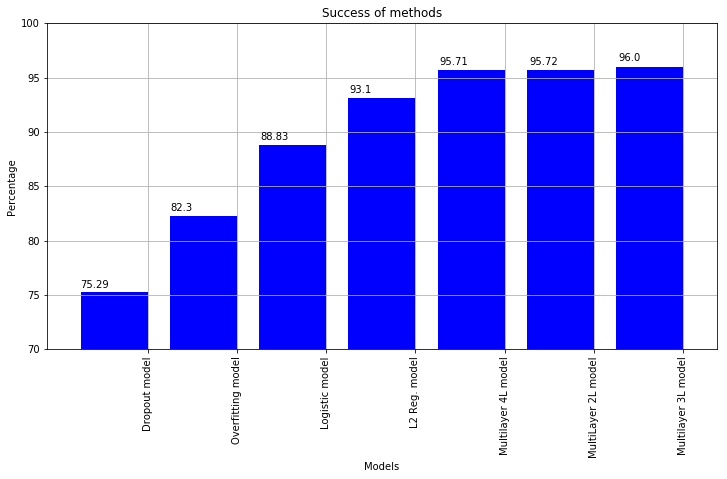

In [89]:
import pandas as pd
from collections import OrderedDict
def plotSuccess():
    s = pd.Series(methodDict)
    s.sort()
    
    # Colors
    ax = s.plot(kind='bar', figsize=(12, 6))

    
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 100.0])
    plt.xlim([-0.5, 7])
    plt.xlabel('Models')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()
plotSuccess()    